In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from math import sqrt

In [2]:
# Disable warnings for clean output
warnings.filterwarnings("ignore")

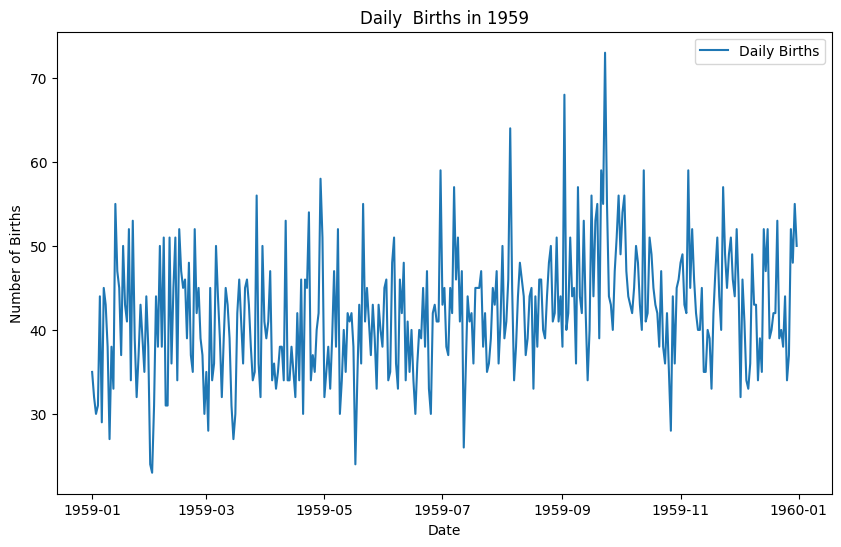

In [3]:
df = pd.read_csv("daily-total-births.csv", parse_dates=['date'], date_parser=pd.to_datetime)
df.columns = ['ds', 'y']
df.head()

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'], label='Daily Births')
plt.title('Daily  Births in 1959')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

21:14:10 - cmdstanpy - INFO - Chain [1] start processing
21:14:10 - cmdstanpy - INFO - Chain [1] done processing


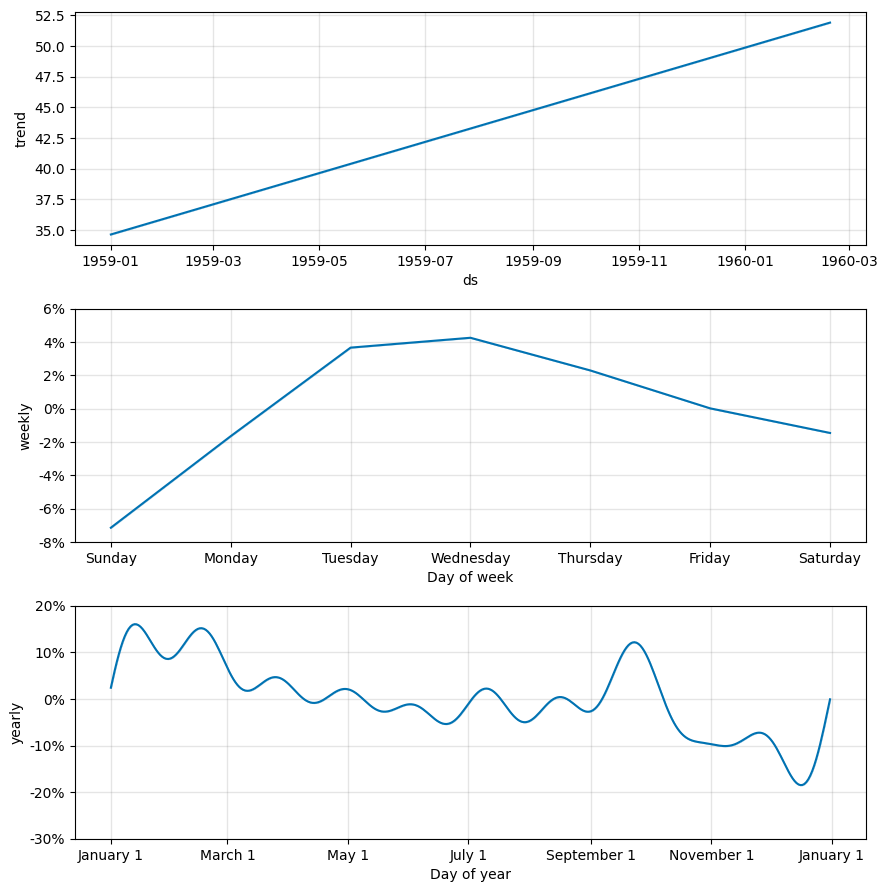

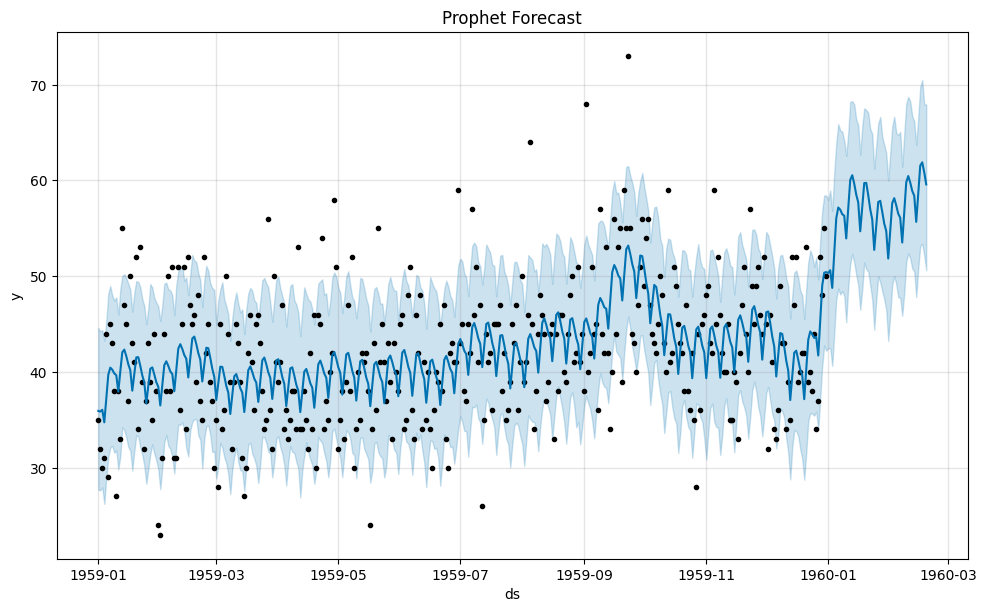

In [4]:
m = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.5, seasonality_mode='multiplicative')
m.fit(df)

# Make future predictions
future = m.make_future_dataframe(periods=50, freq='D')
forecast = m.predict(future)

# Plot forecast components
m.plot_components(forecast)
plt.show()

# Plot forecast
m.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

In [5]:
# ## Evaluate Prophet Model

# Calculate evaluation metrics
y_true = df['y'].values
y_pred = forecast['yhat'][:len(df)].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)

print(f"Prophet Model - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

Prophet Model - MAE: 5.12, MSE: 41.93, RMSE: 6.48


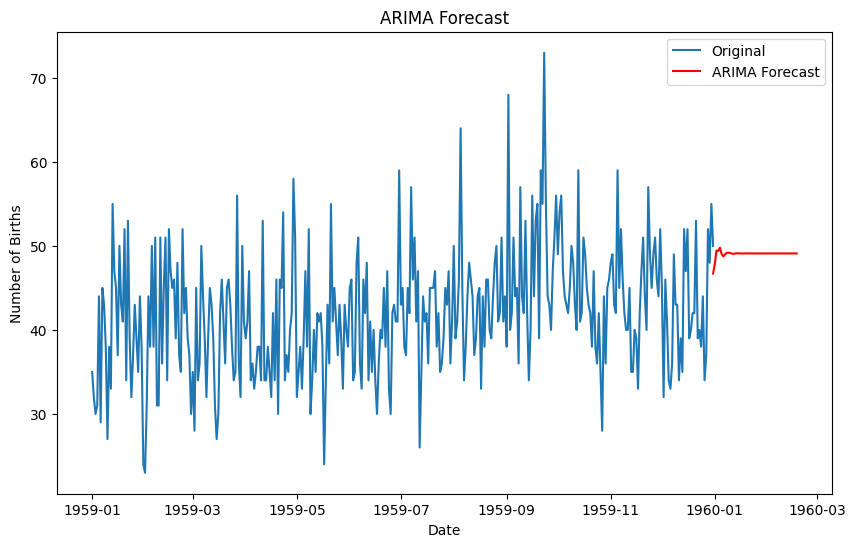

In [6]:
# Fit ARIMA model
arima_model = ARIMA(df['y'], order=(5, 1, 0)).fit()

# Make predictions
arima_forecast = arima_model.predict(start=len(df), end=len(df) + 49, typ='levels')

# Plot ARIMA forecast
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'], label='Original')
plt.plot(pd.date_range(df['ds'].max(), periods=50, freq='D'), arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

In [7]:
# ## Evaluate ARIMA Model

arima_mae = mean_absolute_error(y_true[-50:], arima_forecast[:50])
arima_mse = mean_squared_error(y_true[-50:], arima_forecast[:50])
arima_rmse = sqrt(arima_mse)

print(f"ARIMA Model - MAE: {arima_mae:.2f}, MSE: {arima_mse:.2f}, RMSE: {arima_rmse:.2f}")


ARIMA Model - MAE: 7.25, MSE: 77.08, RMSE: 8.78


Epoch 1/10
286/286 - 1s - 4ms/step - loss: 1099.7834
Epoch 2/10
286/286 - 0s - 1ms/step - loss: 330.0075
Epoch 3/10
286/286 - 0s - 1ms/step - loss: 118.3846
Epoch 4/10
286/286 - 0s - 1ms/step - loss: 68.1635
Epoch 5/10
286/286 - 0s - 1ms/step - loss: 58.0933
Epoch 6/10
286/286 - 0s - 1ms/step - loss: 56.8206
Epoch 7/10
286/286 - 0s - 1ms/step - loss: 56.6504
Epoch 8/10
286/286 - 0s - 1ms/step - loss: 56.5359
Epoch 9/10
286/286 - 0s - 1ms/step - loss: 56.3969
Epoch 10/10
286/286 - 0s - 1ms/step - loss: 55.8724
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


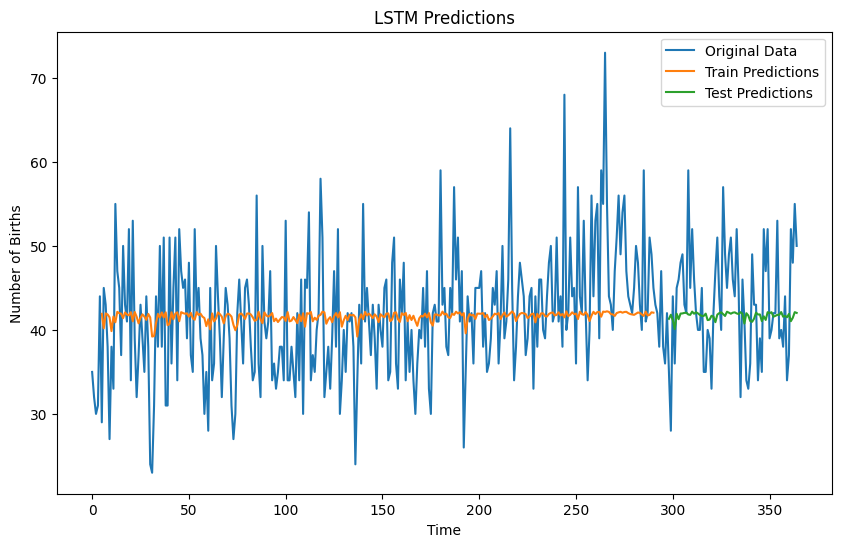

In [8]:
# ## LSTM Model Forecast

# Prepare data for LSTM
data = df['y'].values
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 5
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(look_back, 1)),
    tf.keras.layers.Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

# Make LSTM predictions
lstm_train_pred = lstm_model.predict(X_train)
lstm_test_pred = lstm_model.predict(X_test)

# Plot LSTM predictions
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data')
plt.plot(range(look_back, look_back + len(lstm_train_pred)), lstm_train_pred, label='Train Predictions')
plt.plot(range(len(data) - len(lstm_test_pred), len(data)), lstm_test_pred, label='Test Predictions')
plt.title('LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

In [9]:
# ## Evaluate LSTM Model

lstm_rmse = sqrt(mean_squared_error(y_test, lstm_test_pred))
print(f"LSTM Model - RMSE: {lstm_rmse:.2f}")

LSTM Model - RMSE: 6.59


In [10]:
# ## Conclusion

# Summarize results from all models
results = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA', 'LSTM'],
    'MAE': [mae, arima_mae, None],  # LSTM does not have MAE calculated
    'RMSE': [rmse, arima_rmse, lstm_rmse]
})

print("Model Performance Summary:")
print(results)

Model Performance Summary:
     Model       MAE      RMSE
0  Prophet  5.117505  6.475215
1    ARIMA  7.246497  8.779511
2     LSTM       NaN  6.591240


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -1223.863
Date:                Thu, 17 Oct 2024   AIC                           2463.727
Time:                        21:14:17   BIC                           2494.904
Sample:                             0   HQIC                          2476.118
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8587      0.062    -13.823      0.000      -0.980      -0.737
ar.L2          0.1686      0.078      2.164      0.030       0.016       0.321
ar.L3          0.0483      0.084      0.574      0.5

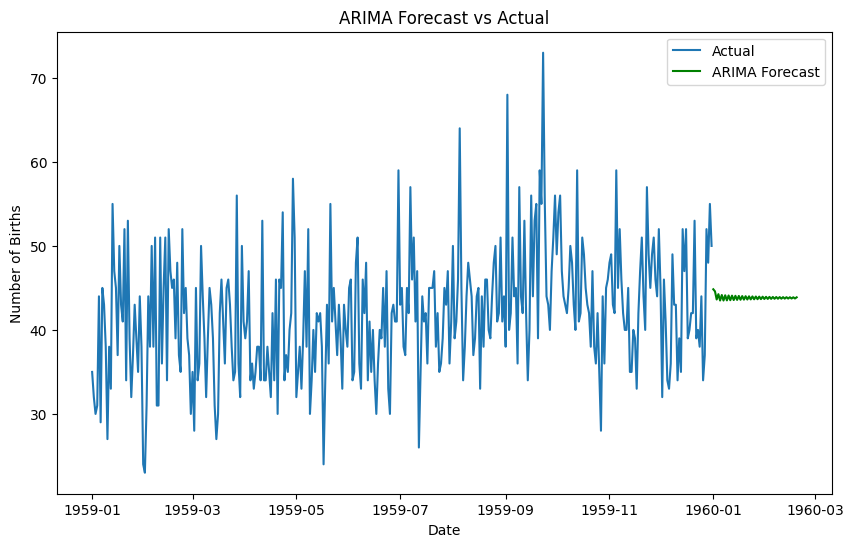

In [11]:

# Fit an ARIMA model for comparison
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA (order p, d, q) - auto-tuning can also be considered
model_arima = ARIMA(df['y'], order=(5, 1, 2))
results_arima = model_arima.fit()
print(results_arima.summary())

# Forecast using ARIMA
arima_forecast = results_arima.forecast(steps=50)

# Plot ARIMA Forecast
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'], label='Actual')
plt.plot(pd.date_range(df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=50), 
         arima_forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()


Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0576
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0229
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0193
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0240
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0198
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0217
Epoch 9/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0236
Epoch 10/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0186
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


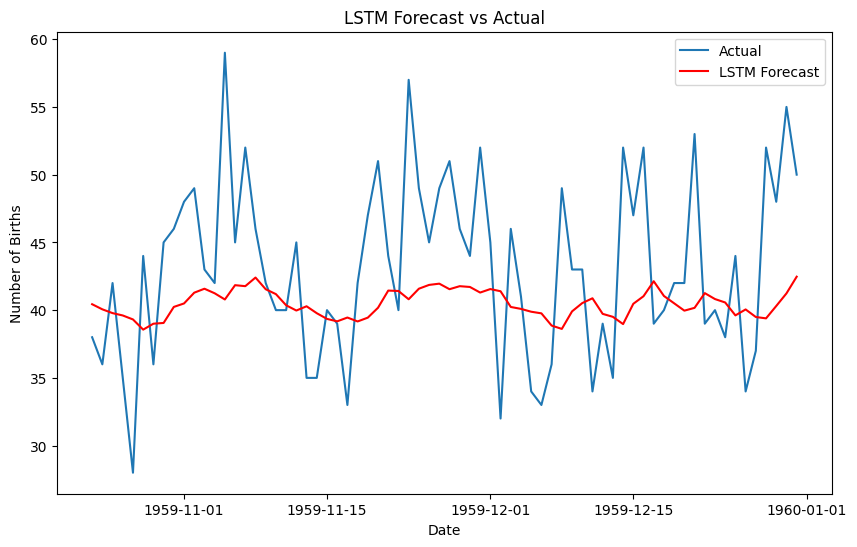

In [12]:

# Prepare data for LSTM model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['y']])

# Prepare training and test data
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], look_back, 1))
X_test = X_test.reshape((X_test.shape[0], look_back, 1))

# Build LSTM Model
model_lstm = Sequential([
    LSTM(50, input_shape=(look_back, 1), return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM Model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

# Forecast with LSTM
lstm_pred = model_lstm.predict(X_test)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)

# Plot LSTM Forecast
plt.figure(figsize=(10, 6))
plt.plot(df['ds'].iloc[train_size + look_back:], df['y'].iloc[train_size + look_back:], label='Actual')
plt.plot(df['ds'].iloc[train_size + look_back:], lstm_pred_rescaled.flatten(), label='LSTM Forecast', color='red')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()


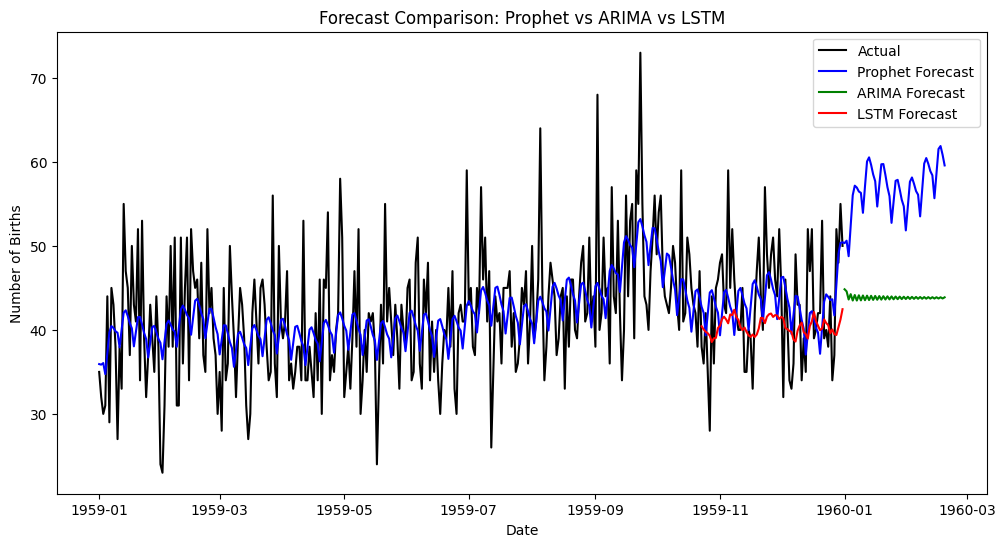

In [13]:

# Plot Prophet, ARIMA, and LSTM forecasts for comparison
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual', color='black')

# Prophet forecast
plt.plot(future['ds'], forecast['yhat'], label='Prophet Forecast', color='blue')

# ARIMA forecast
plt.plot(pd.date_range(df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=50), 
         arima_forecast, label='ARIMA Forecast', color='green')

# LSTM forecast
plt.plot(df['ds'].iloc[train_size + look_back:], lstm_pred_rescaled.flatten(), 
         label='LSTM Forecast', color='red')

plt.title('Forecast Comparison: Prophet vs ARIMA vs LSTM')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()


In [14]:
import pickle
# Assuming `prophet_model` is your trained Prophet model
with open("models/prophet_model.pkl", 'wb') as f:
    pickle.dump(m, f)


In [15]:
# Save the LSTM model
lstm_model.save("models/lstm_model.h5")

# Save the MinMaxScaler used during training
with open("models/scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)


In [16]:
# Save the ARIMA model
with open("models/arima_model.pkl", 'wb') as f:
    pickle.dump(arima_model, f)
